# Import Data

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from model.prediction_engine import get_final_data
# final_data = get_final_data(save_to_csv=False)
final_data = pd.read_csv('data/final_data.csv')

## Process Data

In [3]:
import torch
import tensorly as tl
%load_ext autoreload
%autoreload 2

from model.prediction_engine import PredictionTestEngine

final_data = final_data.sort_values(['year_month', 'GVKEY'])
final_data['trt1m'] = pd.to_numeric(final_data['trt1m'], errors='coerce')

# feature columns
feature_cols = [c for c in final_data.columns 
                if c not in ['GVKEY','year_month','trt1m']]
for col in feature_cols:
    final_data[col] = pd.to_numeric(final_data[col], errors='coerce')

# Build Y (T × n_series)
Y_df = (final_data
    .pivot_table(index='year_month', columns='GVKEY', 
                 values='trt1m', aggfunc='mean')
    .sort_index().sort_index(axis=1)
)
Y_df = Y_df.apply(lambda x: (x - x.mean())/x.std(), axis=0)
Y = Y_df.to_numpy()

# Build X tensor (T × n_series × n_features)
X_list = []
for col in feature_cols:
    pivot = (final_data
        .pivot_table(index='year_month', columns='GVKEY', 
                     values=col, aggfunc='mean')
        .reindex(index=Y_df.index, columns=Y_df.columns)
    )
    pivot = pivot.apply(lambda x: (x - x.mean())/x.std(), axis=0)
    X_list.append(pivot.to_numpy())
X = np.stack(X_list, axis=2)

# Shift so that X[t] predicts Y[t+1]
X_all = np.nan_to_num(X[:-1, :, :])
Y_all = np.nan_to_num(Y[1:, :])

# Time index for the test (use first day of month)
time_index_all = pd.to_datetime(Y_df.index[1:], format='%Y-%m')

# Ensure tensorly backend
tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)



/Users/timothychung/Documents/FYP Code/.venv/lib/python3.12/site-packages/torch/__init__.py:1240: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)


In [3]:
# Instantiate engine
window_size = 70
train_start = int(0.70 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=40, Ln=(6, 6), epsilon=1e-6, verbose=True, n_jobs=7, lambda_X = 1e-4, lambda_Y = 1e-7, alpha=1.2
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=70, n_series=127, n_features=38
run_window: number of test windows=83


Parallel preds: 100%|██████████| 83/83 [13:38<00:00,  9.86s/it] 


ValueError: Found input variables with inconsistent numbers of samples: [10541, 83]

In [ ]:
# Instantiate engine
window_size = 80
train_start = int(0.70 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=40, Ln=(6, 6), epsilon=1e-6, verbose=True, n_jobs=7, lambda_X = 1e-4, lambda_Y = 1e-7, alpha=1.2
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

In [ ]:
# Instantiate engine
window_size = 60
train_start = int(0.70 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=40, Ln=(6, 6), epsilon=1e-6, verbose=True, n_jobs=7, lambda_X = 1e-4, lambda_Y = 1e-7, alpha=4
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

In [ ]:
# Instantiate engine
window_size = 60
train_start = int(0.70 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=50, Ln=(12, 12), epsilon=1e-7, verbose=True, n_jobs=7, lambda_X = 1e-2, lambda_Y = 1e-7, alpha=4
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=80, n_series=127, n_features=38
run_window: number of test windows=110


Parallel preds: 100%|██████████| 110/110 [04:50<00:00,  2.64s/it]


MILR components: 15
  P comp 0: [(127, 20), (38, 20)]
  P comp 1: [(127, 20), (38, 20)]
  P comp 2: [(127, 20), (38, 20)]
  P comp 3: [(127, 20), (38, 20)]
  P comp 4: [(127, 20), (38, 20)]
  P comp 5: [(127, 20), (38, 20)]
  P comp 6: [(127, 20), (38, 20)]
  P comp 7: [(127, 20), (38, 20)]
  P comp 8: [(127, 20), (38, 20)]
  P comp 9: [(127, 20), (38, 20)]
  P comp 10: [(127, 20), (38, 20)]
  P comp 11: [(127, 20), (38, 20)]
  P comp 12: [(127, 20), (38, 20)]
  P comp 13: [(127, 20), (38, 20)]
  P comp 14: [(127, 20), (38, 20)]
G shapes: [(1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20), (1, 20, 20)]
Q shape: (127, 15)
D shape: (15,)
T_mat shape: (80, 15), W_mat shape: (4826, 15)
Overall metrics:
mse: 0.9852
r2: 0.0027
directional_accuracy: 0.5377


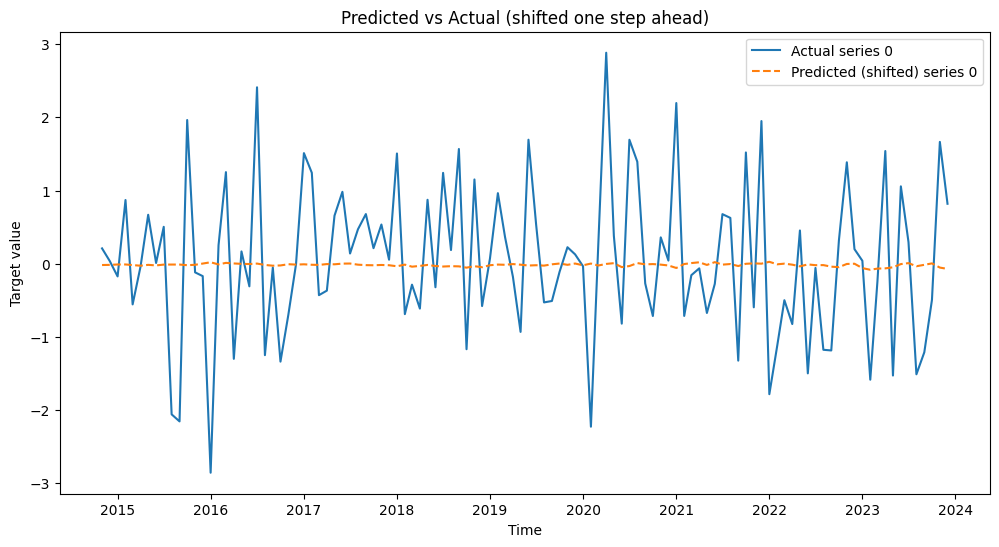

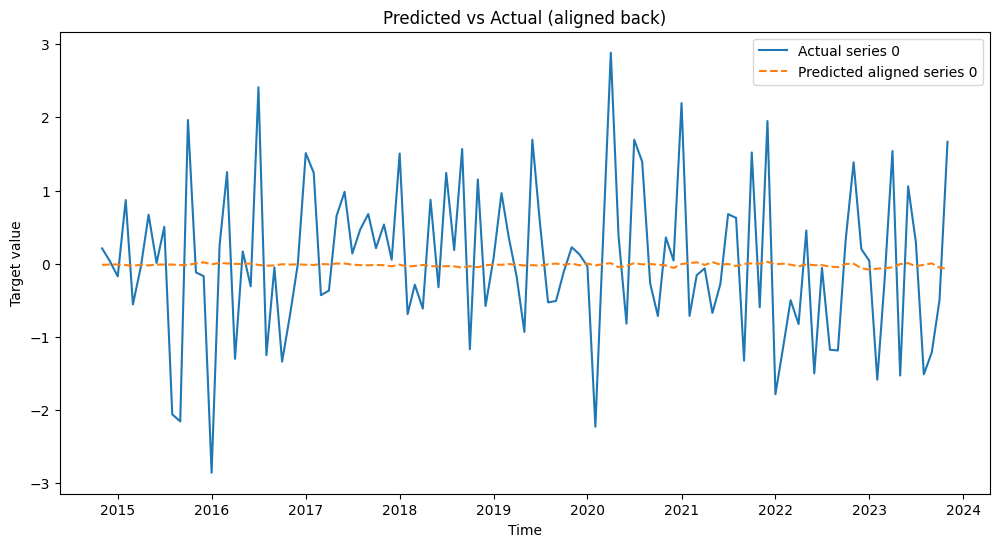

In [5]:
# Instantiate engine
window_size = 80
train_start = int(0.60 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    time_index=time_index_all,
    train_start=train_start,
)

y_pred, y_true, times, metrics = engine.run_window(
    method="hopls_milr"
    , R=15, Ln=(20, 20), epsilon=1e-8, verbose=True, n_jobs=7, lambda_X = 2, lambda_Y = 2, alpha=0.5
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])